# Trabajo Práctico 1 - Compresión de Imágenes

# Librerías:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from IPython.display import HTML

# Ejercicio 1

a) Cargar las imágenes suministradas img 01.jpg y img 02.jpg (convertirlas a escala de grises y a tipo float). Formar bloques de 2 × 1 para definir el vector X = [X1, X2]^T (con X1 y X2 dos píxeles contiguos verticalmente). Hacer un gráfico de dispersión, junto a la imagen asociada, para ver gráficamente cuánta correlación existe entre los dos píxeles vecinos para cada imagen.

b) Estimar el coeficiente de correlación de cada vector. ¿Qué diferencias observa para ambas imágenes? ¿Cuál de ellas podría comprimir la información con una mayor calidad?

In [ ]:
def img_to_vec(img):
    ImgFloat = img.astype(float)
    ImgVec = ImgFloat.T.ravel()
    x1 = ImgVec[::2]
    x2 = ImgVec[1::2]
    return np.vstack([x1, x2]).T

def graficar(x, img, titulo="Imagen"):
    x1 = x[:,0]
    x2 = x[:,1]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img, cmap="gray")
    axes[0].set_title(titulo)

    axes[1].scatter(x1, x2, s=1, alpha=0.5)    
    axes[1].set_xlabel("x1 (pixel de arriba)")   
    axes[1].set_ylabel("x2 (pixel de abajo)") 
    axes[1].set_title("Dispersion de pixeles vecinos")
    
    plt.tight_layout()
    plt.show()

    corr = np.corrcoef(x1, x2) [0, 1]
    display(HTML(f'<p style="font-size: 18px; font-weight: bold;">El coeficiente de correlación es de {corr}</p>'))

img1 = cv2.imread("img_01.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("img_02.jpg", cv2.IMREAD_GRAYSCALE)

v1 = img_to_vec(img1)
v2 = img_to_vec(img2)

graficar(v1, img1, "Imagen 1")
graficar(v2, img2, "Imagen 2")

c) Aplicar una transformación que permita desacoplar las variables de cada vector, haga un gráfico de dispersión de ese nuevo vector y saque conclusiones.

In [ ]:
def descorrelacion(x):
    mu = x.mean(axis=0)
    x_centrado = x - mu

    cov = np.cov(x_centrado, rowvar=False)

    autoval, autovec = np.linalg.eigh(cov)

    idx = np.argsort(autoval)[::-1] #indices de las posiciones ordenadas
    autovec = autovec[:, idx]

    return x_centrado @ autovec #producto entre los datos centrados y los autovectores

def graficar_descorrelacion(x, titulo="Imagen - Vectores descorrelacionados"):
    plt.figure(figsize=(5,5))
    plt.scatter(x[:,0], x[:,1], s=1, alpha=0.5)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(titulo)
    plt.show()


img1 = cv2.imread("img_01.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("img_02.jpg", cv2.IMREAD_GRAYSCALE)

v1 = img_to_vec(img1)
v2 = img_to_vec(img2)

d1 = descorrelacion(v1)
d2 = descorrelacion(v2)

graficar_descorrelacion(d1, "Imagen1 - Vectores descorrelacionados")
graficar_descorrelacion(d2, "Imagen2 - Vectores descorrelacionados")

# Ejercicio 2

a) Para realizar el proceso de compresión será necesario segmentar la imagen en bloques para luego aplicar la reducción de dimensionalidad mediante PCA. Implementar la función pca_transform() que implemente el algoritmo de PCA, ya sea basado en la descomposición de la covarianza o mediante SVD. Nota: no utilice paquetes con funciones que ya resuelvan el algoritmo de PCA.

b) Desarmar la imagen img_03.jpg en bloques de 8×8 y aplicar PCA para obtener los vectores de menor dimensión, tal que el ahorro sea S = 80 %. Haga un gráfico de los autovalores de Cx, diferenciando los que se conservan de los que se descartan.

In [ ]:
def Escala_de_grises(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

def Separar_en_bloques(matriz_img, tam_bloque):
    bloques=[]
    alto,ancho=matriz_img.shape
    for i in range(0,alto,tam_bloque):
        for j in range(0,ancho, tam_bloque):
            bloque = matriz_img[i:i+tam_bloque, j:j+tam_bloque]
            if bloque.shape == (tam_bloque, tam_bloque):
                bloque=bloque.reshape(-1,1,order='F')
                bloques.append(bloque)
    return np.array(bloques)

def pca_transform(X_centrado,porcentaje_de_espacio):
    _,dim_vector,_ =X_centrado.shape
    k=(porcentaje_de_espacio/100)-1
    k*=-dim_vector
    k=round(k)
    X2D = X_centrado.squeeze(-1)  
    U, S, VT = np.linalg.svd(X2D, full_matrices=False)
    U_k= U[:,:k]
    S_k=np.diag(S[:k])
    VT_k = VT[:k, :]        
    return U_k,S_k,VT_k
    
def comprimir(img_path, tam_bloque):
    Imagen_escalada=Escala_de_grises(img_path)
    X=Separar_en_bloques(Imagen_escalada,tam_bloque)
    Media_X = np.mean(X, axis=1, keepdims=True)  
    X_centrado = X - Media_X
    Graficar_comparacion(X_centrado)
    U_k,S_k,VT_k=pca_transform(X_centrado,80)
    Y_k = U_k @ S_k  
    
    return Y_k, Media_X, VT_k

def Graficar_comparacion(X_centrado, k=13):
    X2D = X_centrado.squeeze(-1)
    n, m = X2D.shape
    U, S, VT = np.linalg.svd(X2D)
    autovalores = (S**2) / (n - 1) 
    colors = ['tab:blue' if i < k else 'tab:gray' for i in range(len(autovalores))]

    # Gráfico de barras para autovalores
    fig, ax1 = plt.subplots(figsize=(10, 5))
    indices = np.arange(1, len(autovalores) + 1)
    ax1.bar(indices, autovalores, color=colors, alpha=0.8)
    ax1.set_xlabel('Índice del componente (orden descendente)')
    ax1.set_ylabel('Autovalores de $C_X$')
    ax1.set_title(f'Autovalores de $C_X$ (nxm={n}{m}) — primeros {k} conservados')

    # Línea vertical indicando límite k
    ax1.axvline(k + 0.5, color='red', linestyle='--', linewidth=1)
    ax1.text(k + 1, max(autovalores) * 0.9, f'k = {k}', color='red')

    plt.tight_layout()
    plt.show()

# Ejercicio 3

a) En base a los datos del Ejercicio anterior, implementar el proceso inverso, teniendo en cuenta la transformación que revierte la compresión y el vector de medias. Regenerar la imagen a partir de los vectores reconstruidos.

In [ ]:
def descomprimir(matriz_Y_k, Media_X, VT_k):
    Xreconstruida = (np.array(matriz_Y_k) @ np.array(VT_k))[:, :, None] + np.array(Media_X)
    n = Xreconstruida.shape[0]
    X_recon = np.zeros((n, 8, 8))
    for i in range(n):
        X_recon[i] = Xreconstruida[i].reshape(8, 8, order='F')
    
    return X_recon
    
path=r"img_03.jpg"


y,mu,vt=comprimir(path,8)
X_reconstruida = descomprimir(y, mu, vt)

Imagen_escalada = Escala_de_grises(path)
alto, ancho = Imagen_escalada.shape

def recomponer_imagen(bloques, alto, ancho, tam_bloque=8):

    alto_ajustado = (alto // tam_bloque) * tam_bloque
    ancho_ajustado = (ancho // tam_bloque) * tam_bloque
    
    imagen = np.zeros((alto_ajustado, ancho_ajustado))
    bloques_por_fila = ancho_ajustado // tam_bloque
    
    for idx, bloque in enumerate(bloques):
        if idx < len(bloques):
            fila = (idx // bloques_por_fila) * tam_bloque
            col = (idx % bloques_por_fila) * tam_bloque
            imagen[fila:fila+tam_bloque, col:col+tam_bloque] = bloque 
    return imagen

img_final = recomponer_imagen(X_reconstruida,alto,ancho,8)

b) Graficar con la imagen luego de la reconstrucción y compararla con la original.

In [ ]:
imagen_original = Escala_de_grises(path)

# Crear subplots para mostrar ambas imágenes y graficarlas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(imagen_original, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')
axes[1].imshow(img_final, cmap='gray')
axes[1].set_title('Imagen Reconstruida (S=80%)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Ejercicio 4

a) Abrir la imagen img 04.jpg, calcular y graficar MSE en función de diferentes porcentajes de espacio ahorrado S = {5n : n = 1, 2, ..., 19}.

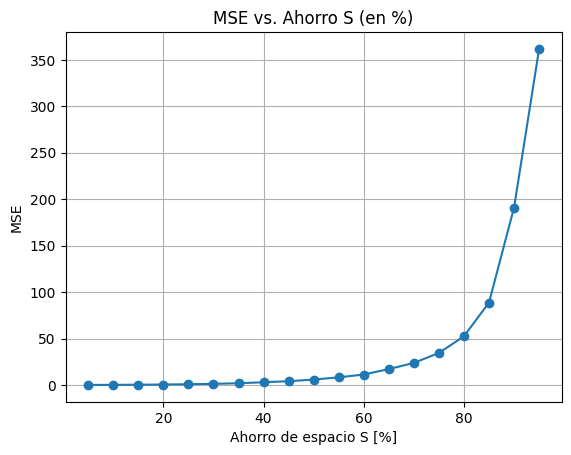

In [51]:
# ---------- utilidades ----------
def Escala_de_grises(img_path):
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

def Separar_en_bloques(matriz_img, tam_bloque):
    bloques=[]
    alto,ancho=matriz_img.shape
    for i in range(0,alto,tam_bloque):
        for j in range(0,ancho, tam_bloque):
            bloque = matriz_img[i:i+tam_bloque, j:j+tam_bloque]
            if bloque.shape == (tam_bloque, tam_bloque):
                bloque=bloque.reshape(-1,1,order='F')
                bloques.append(bloque)
    return np.array(bloques)

def pca_transform(X_centrado,porcentaje_de_espacio):
    _,dim_vector,_ =X_centrado.shape
    k=(porcentaje_de_espacio/100)-1
    k*=-dim_vector
    k=round(k)
    X2D = X_centrado.squeeze(-1)  
    U, S, VT = np.linalg.svd(X2D, full_matrices=False)
    U_k= U[:,:k]
    S_k=np.diag(S[:k])
    VT_k = VT[:k, :]        
    return U_k,S_k,VT_k
    
def comprimir(img_path, tam_bloque, porcentaje = 80):
    Imagen_escalada=Escala_de_grises(img_path)
    X=Separar_en_bloques(Imagen_escalada,tam_bloque)
    Media_X = np.mean(X, axis=1, keepdims=True)  
    X_centrado = X - Media_X
    U_k,S_k,VT_k=pca_transform(X_centrado,porcentaje)
    Y_k = U_k @ S_k  
    
    return Y_k, Media_X, VT_k

def descomprimir(matriz_Y_k, Media_X, VT_k):
    Xreconstruida = (np.array(matriz_Y_k) @ np.array(VT_k))[:, :, None] + np.array(Media_X)
    n = Xreconstruida.shape[0]
    X_recon = np.zeros((n, 8, 8))
    for i in range(n):
        X_recon[i] = Xreconstruida[i].reshape(8, 8, order='F')
    
    return X_recon
    
def recomponer_imagen(bloques, alto, ancho, tam_bloque=8):

    alto_ajustado = (alto // tam_bloque) * tam_bloque
    ancho_ajustado = (ancho // tam_bloque) * tam_bloque
    
    imagen = np.zeros((alto_ajustado, ancho_ajustado))
    bloques_por_fila = ancho_ajustado // tam_bloque
    
    for idx, bloque in enumerate(bloques):
        if idx < len(bloques):
            fila = (idx // bloques_por_fila) * tam_bloque
            col = (idx % bloques_por_fila) * tam_bloque
            imagen[fila:fila+tam_bloque, col:col+tam_bloque] = bloque 
    return imagen

# Gráfico MSE vs Porcentaje de ahorro

def mse(a, b):
    min_h = min(a.shape[0], b.shape[0])
    min_w = min(a.shape[1], b.shape[1])
    
    a_crop = a[:min_h, :min_w]
    b_crop = b[:min_h, :min_w]
    
    return float(np.mean((a_crop - b_crop) ** 2))

def Graficar_MSE_vs_S(path, porcentajes):
    Imagen_escalada = Escala_de_grises(path)
    alto, ancho = Imagen_escalada.shape
    
    mses = []
    
    for porcentaje in porcentajes:
        Y_k, U_k, Media_X = comprimir(path, 8, porcentaje)
        X_reconstruida = descomprimir(Y_k, U_k, Media_X)
        img_final = recomponer_imagen(X_reconstruida, alto, ancho, 8)
        
        MSE_value = mse(Imagen_escalada, img_final)
        mses.append(MSE_value)
        #print(f"Ahorro {porcentaje}%: MSE = {MSE_value:.1f}")
    
    # Grafico
    plt.plot(porcentajes, mses, marker='o')
    plt.xlabel('Ahorro de espacio S [%]')
    plt.ylabel('MSE')
    plt.title('MSE vs. Ahorro S (en %)')
    plt.grid(True)
    plt.show()

# ---------- Ejecución ----------
path = r"img_04.jpg"
porcentajes = list(range(5, 100, 5)) 

Graficar_MSE_vs_S(path, porcentajes)

# b)

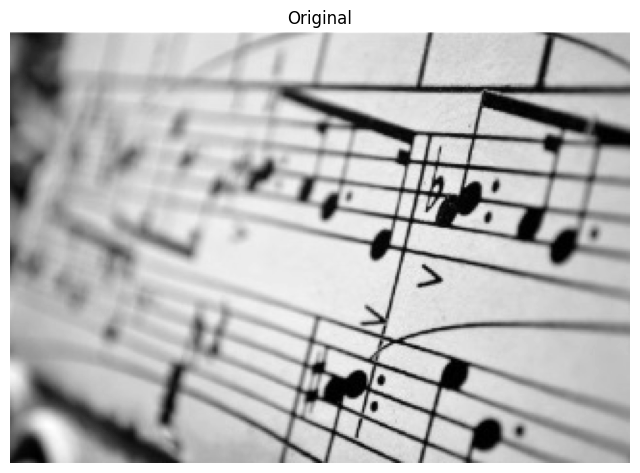

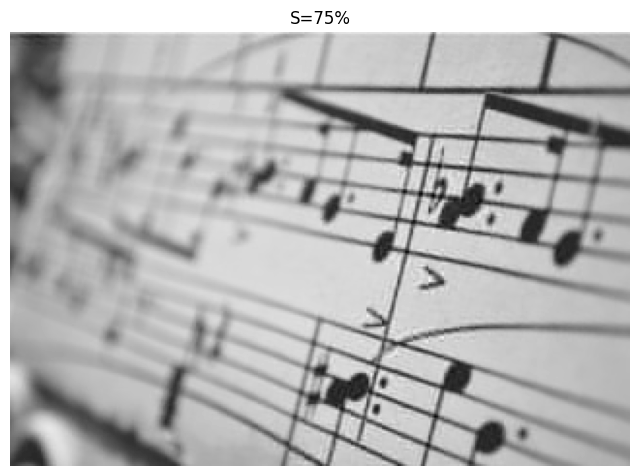

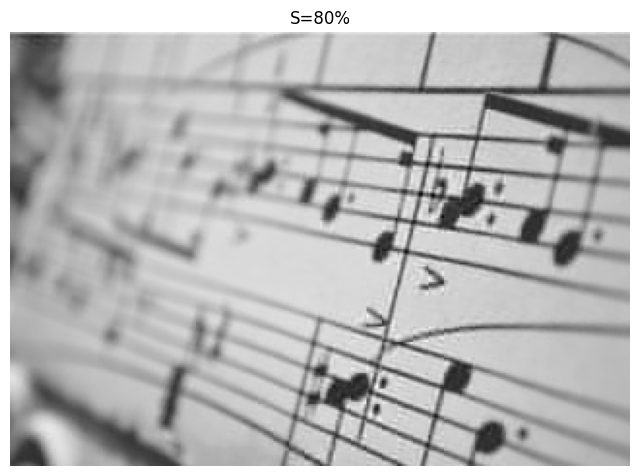

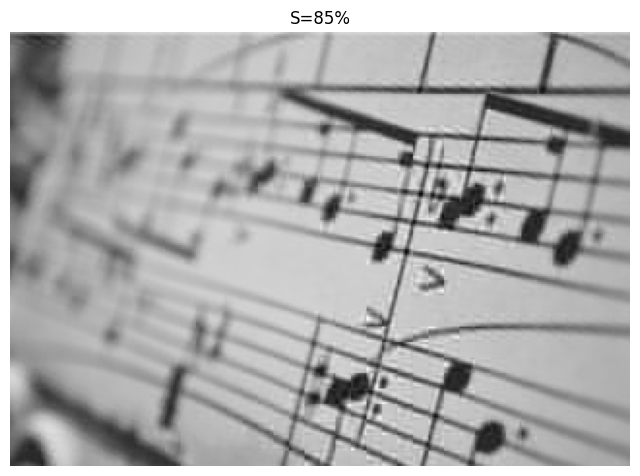

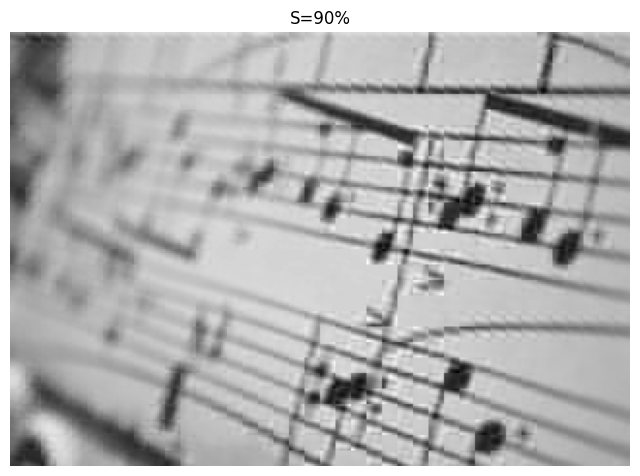

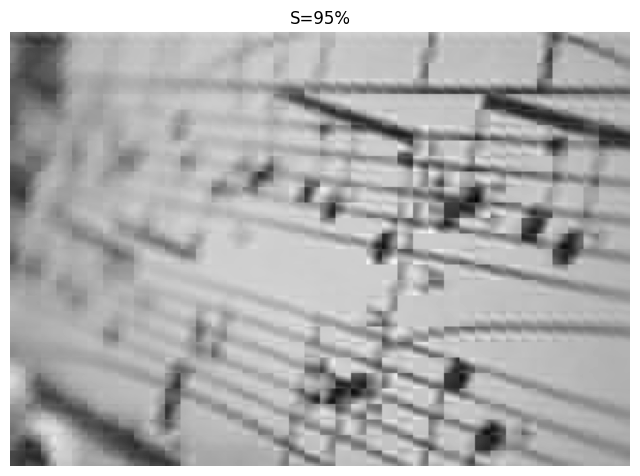

In [67]:
def mostrar_imagenes(path, porcentajes_ahorro):
    """
    Muestra cada imagen por separado
    """
    # Cargar imagen original
    imagen_original = Escala_de_grises(path)
    alto, ancho = imagen_original.shape
    
    # Mostrar imagen original
    fig = plt.figure(figsize=(8,6))
    plt.imshow(imagen_original, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.show()
    
    # Mostrar cada imagen comprimida por separado
    for porcentaje in porcentajes_ahorro:
        # Comprimir y reconstruir
        Y_k, Media_X, VT_k = comprimir(path, 8, porcentaje)
        X_reconstruida = descomprimir(Y_k, Media_X, VT_k)
        img_reconstruida = recomponer_imagen(X_reconstruida, alto, ancho, 8)
        
        # Mostrar imagen
        fig = plt.figure(figsize=(8,6))
        plt.imshow(img_reconstruida, cmap='gray')
        plt.title(f"S={porcentaje}%")
        plt.axis('off')
        plt.show()

# -------- Ejecución ---------
path = r"img_04.jpg"
porcentajes_ahorro = [75, 80, 85, 90, 95]

mostrar_imagenes(path, porcentajes_ahorro)